In [1]:
"""
Compute Starlink satellites that satisfy user-defined
elevation / azimuth / range constraints and express their
locations in a local ENU Cartesian frame whose origin is the
ground station (x = East, y = North, z = Up).
"""

import numpy as np
import pandas as pd
import requests
from skyfield.api import load, EarthSatellite, wgs84
from skyfield.framelib import itrs  # Earth-fixed ITRF frame
ts = load.timescale()


# ───────────────────────────────────────────────────────────────
# 3) Download Starlink TLEs and append satellites
# ----------------------------------------------------------------
url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle"
HEADERS = {"User-Agent": "sat-tracker/1.0 (+https://github.com/you/repo)"}
tle_lines = requests.get(url, timeout=10).text.strip().splitlines()

sats = []
for i in range(0, len(tle_lines) - 2, 3):  # Process full TLE blocks
    name = tle_lines[i].strip()
    l1 = tle_lines[i+1].strip()
    l2 = tle_lines[i+2].strip()
    if not (l1.startswith("1 ") and l2.startswith("2 ")):
        continue
    try:
        sats.append((name, EarthSatellite(l1, l2, name, ts)))
    except ValueError:
        continue
    
    


In [3]:
from datetime import datetime, timedelta
from skyfield.api import utc
import numpy as np
import pandas as pd

# ───────────────────────────────────────────────────────────────
# Observer definition (Boulder, CO)
# ----------------------------------------------------------------
lat, lon, elev = 40.0822, -105.1092, 1560  # meters
topos = wgs84.latlon(lat, lon, elev)

# Build ECEF → ENU rotation matrix
phi = np.radians(lat)
lam = np.radians(lon)
R_ecef2enu = np.array([
    [-np.sin(lam),              np.cos(lam),               0.0],
    [-np.sin(phi)*np.cos(lam), -np.sin(phi)*np.sin(lam),  np.cos(phi)],
    [ np.cos(phi)*np.cos(lam),  np.cos(phi)*np.sin(lam),  np.sin(phi)]
])

# ───────────────────────────────────────────────────────────────
# Sampling every 5 seconds for 15 minutes
# ----------------------------------------------------------------
ELEV_MIN_DEG = 30
AZ_RANGE_DEG = (0, 360)
MAX_SLANT_KM = 9999
DURATION_SEC = 15 * 60         # 15 minutes
INTERVAL_SEC = 10               # 5-second interval

rows = []
start_time = datetime.utcnow().replace(tzinfo=utc)

for i in range(0, DURATION_SEC, INTERVAL_SEC):
    current_dt = start_time + timedelta(seconds=i)
    t = ts.utc(current_dt)

    for name, sat in sats:
        alt, az, dist = (sat - topos).at(t).altaz()
        if alt.degrees < ELEV_MIN_DEG:
            continue
        if not (AZ_RANGE_DEG[0] <= az.degrees < AZ_RANGE_DEG[1]):
            continue
        if dist.km > MAX_SLANT_KM:
            continue

        sat_ecef = sat.at(t).frame_xyz(itrs).m
        obs_ecef = topos.at(t).frame_xyz(itrs).m
        enu = R_ecef2enu @ (sat_ecef - obs_ecef)

        rows.append([
            current_dt.strftime("%Y-%m-%d %H:%M:%S"),
            name,
            round(az.degrees, 2),
            round(alt.degrees, 2),
            round(dist.km, 1),
            *np.round(enu, 1)
        ])

# ───────────────────────────────────────────────────────────────
# Save to CSV
# ----------------------------------------------------------------
columns = ["Time", "Name", "Azimuth (°)", "Elevation (°)", "Slant km",
           "x_East (m)", "y_North (m)", "z_Up (m)"]
df = pd.DataFrame(rows, columns=columns)

df = df.sort_values(by=["Time", "Slant km"]).reset_index(drop=True)
df.to_csv("starlink_visibility_15min_10s_interval.csv", index=False)


In [2]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from skyfield.api import wgs84, utc
from skyfield.framelib import itrs

def collect_starlink_samples(
    sats,
    ts,
    lat_deg,
    lon_deg,
    elev_m,
    ELEV_MIN_DEG,
    AZ_RANGE_DEG,
    MAX_SLANT_KM,
    mode,
    start_time_utc=None,
    DURATION_SEC=None,
    INTERVAL_SEC=None,
    RANGE_HOURS=None,
    N_SAMPLES=None,
    rng_seed=None,
    out_csv=None,
):
    """Collect Starlink satellite samples that meet visibility constraints (outputs ENU coordinates)."""

    # --- Build observer and rotation matrix ---
    topos = wgs84.latlon(lat_deg, lon_deg, elev_m)
    phi = np.radians(lat_deg)
    lam = np.radians(lon_deg)
    R_ecef2enu = np.array([
        [-np.sin(lam),              np.cos(lam),               0.0],
        [-np.sin(phi)*np.cos(lam), -np.sin(phi)*np.sin(lam),  np.cos(phi)],
        [ np.cos(phi)*np.cos(lam),  np.cos(phi)*np.sin(lam),  np.sin(phi)]
    ])

    # --- Generate time samples ---
    def now_utc():
        return datetime.utcnow().replace(tzinfo=utc)

    if mode == "timeseries":
        t0 = start_time_utc if start_time_utc else now_utc()
        times_utc = [t0 + timedelta(seconds=s)
                     for s in range(0, int(DURATION_SEC), int(INTERVAL_SEC))]
    elif mode == "random":
        rng = np.random.default_rng(rng_seed)
        t0 = now_utc()
        rand_seconds = rng.uniform(0, RANGE_HOURS * 3600, size=N_SAMPLES)
        rand_seconds.sort()
        times_utc = [t0 + timedelta(seconds=float(s)) for s in rand_seconds]
    else:
        raise ValueError("mode must be 'timeseries' or 'random'")

    # --- Azimuth check (supports wrap-around) ---
    az_lo, az_hi = AZ_RANGE_DEG
    def az_in_range(az_deg):
        az = az_deg % 360
        lo, hi = az_lo % 360, az_hi % 360
        if lo == hi:
            return True
        if lo < hi:
            return lo <= az < hi
        else:
            return az >= lo or az < hi

    # --- Main loop ---
    rows = []
    for dt_utc in times_utc:
        t = ts.utc(dt_utc)
        for name, sat in sats:
            try:
                alt, az, dist = (sat - topos).at(t).altaz()
                # Skip invalid or filtered satellites
                if not np.isfinite([alt.degrees, az.degrees, dist.km]).all():
                    continue
                if alt.degrees < ELEV_MIN_DEG:
                    continue
                if not az_in_range(az.degrees):
                    continue
                if dist.km > MAX_SLANT_KM:
                    continue

                sat_ecef = sat.at(t).frame_xyz(itrs).m
                obs_ecef = topos.at(t).frame_xyz(itrs).m
                if not np.isfinite(sat_ecef).all() or not np.isfinite(obs_ecef).all():
                    continue

                enu = R_ecef2enu @ (sat_ecef - obs_ecef)
                if not np.isfinite(enu).all():
                    continue

                rows.append([
                    dt_utc.strftime("%Y-%m-%d %H:%M:%S"),
                    name,
                    round(az.degrees, 2),
                    round(alt.degrees, 2),
                    round(dist.km, 1),
                    *np.round(enu, 1)
                ])
            except Exception:
                continue  # Skip any problematic satellites or times

    # --- Output DataFrame ---
    columns = ["Time", "Name", "Azimuth (°)", "Elevation (°)", "Slant km",
               "x_East (m)", "y_North (m)", "z_Up (m)"]
    df = pd.DataFrame(rows, columns=columns)

    # Drop rows with any missing or invalid values
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df = df.sort_values(["Time", "Slant km"]).reset_index(drop=True)

    # Save if requested
    if out_csv:
        df.to_csv(out_csv, index=False)
    return df


In [ ]:


lat_deg, lon_deg, elev_m = 40.0822, -105.1092, 1560   # Boulder, CO

# ---- Visibility filters ----
ELEV_MIN_DEG = 45           # Minimum elevation above horizon [deg]
AZ_RANGE_DEG = (0, 360)     # Allowed azimuth range [deg]
MAX_SLANT_KM = 9999          # Maximum slant distance [km]

# ---- Time-series mode parameters ----
DURATION_SEC = 15 * 60      # Total duration [s]
INTERVAL_SEC = 10           # Time step [s]

# ---- Random mode parameters ----
RANGE_HOURS = 24            # Random times within this future window [hours]
N_SAMPLES = 400             # Number of random samples
rng_seed = None               # Random seed for reproducibility

# ---- Run sampling ----
df = collect_starlink_samples(
    sats, ts,
    lat_deg=lat_deg,
    lon_deg=lon_deg,
    elev_m=elev_m,
    ELEV_MIN_DEG=ELEV_MIN_DEG,
    AZ_RANGE_DEG=AZ_RANGE_DEG,
    MAX_SLANT_KM=MAX_SLANT_KM,
    mode="random",                # "random" or "timeseries"
    # start_time_utc=datetime(2025, 10, 6, 12, 0, 0, tzinfo=utc),
    DURATION_SEC=DURATION_SEC,
    INTERVAL_SEC=INTERVAL_SEC,
    RANGE_HOURS=RANGE_HOURS,
    N_SAMPLES=N_SAMPLES,
    rng_seed=None  ,
    out_csv="starlink_randtimepoint_400.csv"
)



/tmp/ipykernel_32440/2616298525.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("tab10")


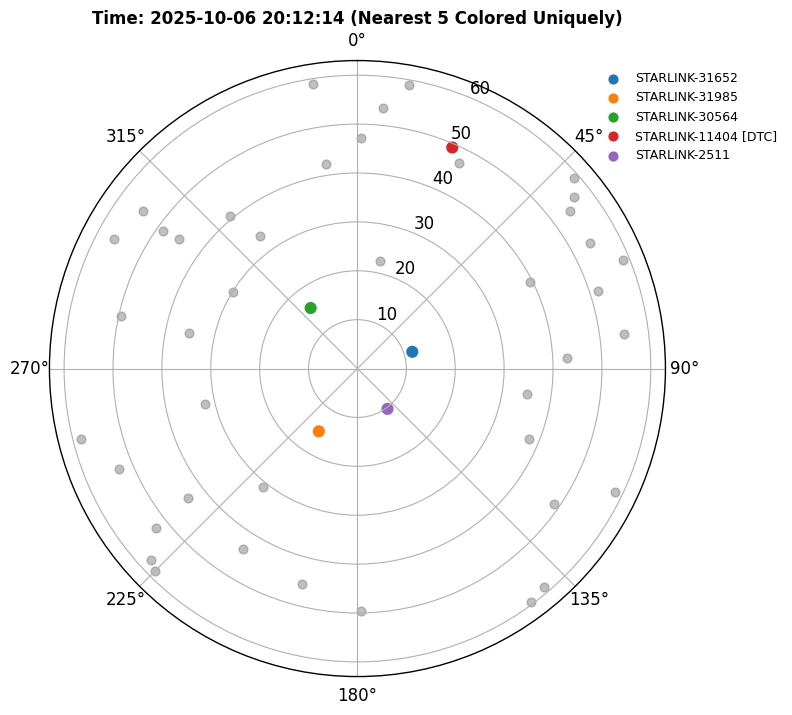

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import itertools
from matplotlib import cm

# Load CSV
df = pd.read_csv("starlink_visibility_15min_10s_interval.csv")
grouped = df.groupby("Time")
time_points = list(grouped.groups.keys())


# Color generator from tab20 (20 unique colors, looped if exhausted)
colormap = cm.get_cmap("tab10")
color_palette = itertools.cycle([colormap(i) for i in range(20)])

global_color_map = {}  # name → color

# Setup figure
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(0, 90 - ELEV_MIN_DEG + 3)

scat_top5 = ax.scatter([], [], s=60)
scat_others = ax.scatter([], [], s=40, c='gray', alpha=0.5)
title_text = ax.set_title("", fontsize=12)

# Initialize legend handles
legend_handles = []

def update(frame):
    global legend_handles
    time = time_points[frame]
    data = grouped.get_group(time).sort_values(by="Slant km")

    top5 = data.head(5)
    others = data.iloc[5:]

    # Assign new color if satellite never seen before
    for name in top5["Name"]:
        if name not in global_color_map:
            global_color_map[name] = next(color_palette)

    # Extract coordinates
    theta_top5 = np.radians(top5["Azimuth (°)"])
    radius_top5 = 90 - top5["Elevation (°)"]
    colors_top5 = [global_color_map[name] for name in top5["Name"]]

    theta_others = np.radians(others["Azimuth (°)"])
    radius_others = 90 - others["Elevation (°)"]

    # Update scatter plot
    scat_top5.set_offsets(np.c_[theta_top5, radius_top5])
    scat_top5.set_color(colors_top5)

    scat_others.set_offsets(np.c_[theta_others, radius_others])
    title_text.set_text(f"Time: {time} (Nearest 5 Colored Uniquely)")

    # Update legend
    for h in legend_handles:
        h.remove()
    legend_handles = []

    for name in top5["Name"]:
        color = global_color_map[name]
        h = ax.scatter([], [], c=[color], label=name, s=40)
        legend_handles.append(h)

    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize=9, frameon=False)

    return scat_top5, scat_others, title_text, *legend_handles

ani = FuncAnimation(fig, update, frames=len(time_points), interval=200, blit=False)
ani.save("starlink_unique_color.gif", dpi=120, writer="pillow")

# Or save as mp4
# ani.save("starlink_unique_color.mp4", dpi=120, writer="ffmpeg")


/tmp/ipykernel_30780/1301488638.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap   = cm.get_cmap("tab10")


Saved: result_plot/starlink_singlecol_polar_notitle.png, result_plot/starlink_singlecol_polar_notitle.pdf


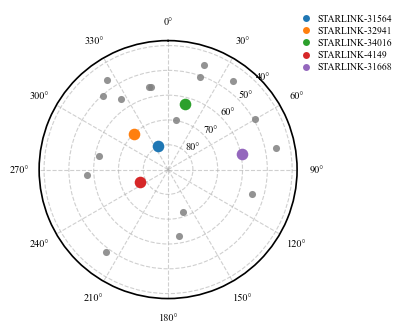

In [31]:
# =========================
# Starlink sky plot (IEEE single-column, title-free, saves to result_plot/)
# =========================
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path

# ========= Config =========
CSV_PATH       = Path("starlink_randtimepoint_400.csv")
ELEV_MIN_DEG   = 40            # outer rim = min elevation
N_TOP          = 5             # number of nearest satellites to color
RANDOM_SEED    = None          # set e.g. 42 for reproducibility
FIG_SIZE_IN    = (3.35, 3.35)  # ≈ IEEE single-column width
DPI_SAVE       = 800
OUT_DIR        = Path("result_plot")
OUT_PNG        = OUT_DIR / "starlink_singlecol_polar_notitle.png"
OUT_PDF        = OUT_DIR / "starlink_singlecol_polar_notitle.pdf"
# =========================

# ---------- Typography (Times New Roman, IEEE-friendly) ----------
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "pdf.fonttype": 42,   # embed TTF in PDF
    "ps.fonttype": 42,
    "mathtext.fontset": "custom",
    "mathtext.rm": "Times New Roman",
    "mathtext.it": "Times New Roman:italic",
    "mathtext.bf": "Times New Roman:bold",
    "font.size": 8.0,
    "axes.labelsize": 8.0,
    "xtick.labelsize": 7.4,
    "ytick.labelsize": 7.4,
    "lines.linewidth": 1.0,
})

# ---------- Read data ----------
df = pd.read_csv(CSV_PATH)
required_cols = ["Time", "Name", "Azimuth (°)", "Elevation (°)", "Slant km"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# Choose one timestamp (random or deterministic)
grouped = df.groupby("Time")
time_points = list(grouped.groups.keys())
rng = np.random.default_rng(RANDOM_SEED)
time = rng.choice(time_points)

data  = grouped.get_group(time).sort_values(by="Slant km")
topN  = data.head(N_TOP).copy()
others = data.iloc[N_TOP:].copy()

# Clip elevations to [ELEV_MIN_DEG, 90] so the ring is clean
topN["Elevation (°)"]   = topN["Elevation (°)"].clip(ELEV_MIN_DEG, 90)
others["Elevation (°)"] = others["Elevation (°)"].clip(ELEV_MIN_DEG, 90)

# ---------- Polar coordinates ----------
theta_top   = np.deg2rad(topN["Azimuth (°)"].to_numpy())
radius_top  = 90 - topN["Elevation (°)"].to_numpy()
theta_oth   = np.deg2rad(others["Azimuth (°)"].to_numpy())
radius_oth  = 90 - others["Elevation (°)"].to_numpy()

# ---------- Colors ----------
colormap   = cm.get_cmap("tab10")
colors_top = [colormap(i) for i in range(N_TOP)]

# ---------- Plot ----------
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=FIG_SIZE_IN)

# North=0°, clockwise azimuth
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Radius range: center=90°, outer rim=ELEV_MIN_DEG (+ small padding)
r_outer = 90 - ELEV_MIN_DEG
ax.set_rlim(0, r_outer + 2)

# Grid and style (light, unobtrusive)
ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.6)
ax.set_axisbelow(True)
ax.set_facecolor("white")

# r-ticks (elevation labels)
rticks = np.arange(10, r_outer + 0.1, 10)
ax.set_yticks(rticks)
ax.set_yticklabels([f"{90 - r:.0f}°" for r in rticks])
ax.set_rlabel_position(45)

# Azimuth ticks: 0°–330° every 30°
ax.set_thetagrids(np.arange(0, 360, 30), labels=[f"{a}°" for a in np.arange(0, 360, 30)])

# Draw the outer elevation ring for clarity
# t = np.linspace(0, 2*np.pi, 720)
# ax.plot(t, np.full_like(t, r_outer), linewidth=1.1, alpha=0.9)

# Points
ax.scatter(theta_oth, radius_oth, s=26, c="gray", alpha=0.85, linewidths=0, zorder=1)
for i, (th, rr) in enumerate(zip(theta_top, radius_top)):
    ax.scatter([th], [rr], s=70, c=[colors_top[i]], linewidths=0, zorder=3)

# Legend (compact, outside right so plot stays large within one column)
legend_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               markerfacecolor=colors_top[i], markeredgecolor='none',
               markersize=5,
               label=str(nm).replace(" [DTC]", "").replace("[DTC]", ""))
    for i, nm in enumerate(topN["Name"])
]
ax.legend(
    handles=legend_handles,
    loc='upper left',
    bbox_to_anchor=(0.98, 1.12),   # outside, right of axes
    borderaxespad=0.0,
    frameon=False,
    fontsize=7.0,
    handletextpad=0.22,
    labelspacing=0.22,
    columnspacing=0.55,
)

# No title (IEEE caption will describe it)

# ---------- Save ----------
OUT_DIR.mkdir(parents=True, exist_ok=True)
fig.savefig(OUT_PNG, dpi=DPI_SAVE, bbox_inches="tight")
fig.savefig(OUT_PDF, dpi=DPI_SAVE, bbox_inches="tight")
print(f"Saved: {OUT_PNG}, {OUT_PDF}")


/tmp/ipykernel_76818/1387924782.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("tab10")


Saved: starlink_sky_ieee_tuned.png, starlink_sky_ieee_tuned.pdf


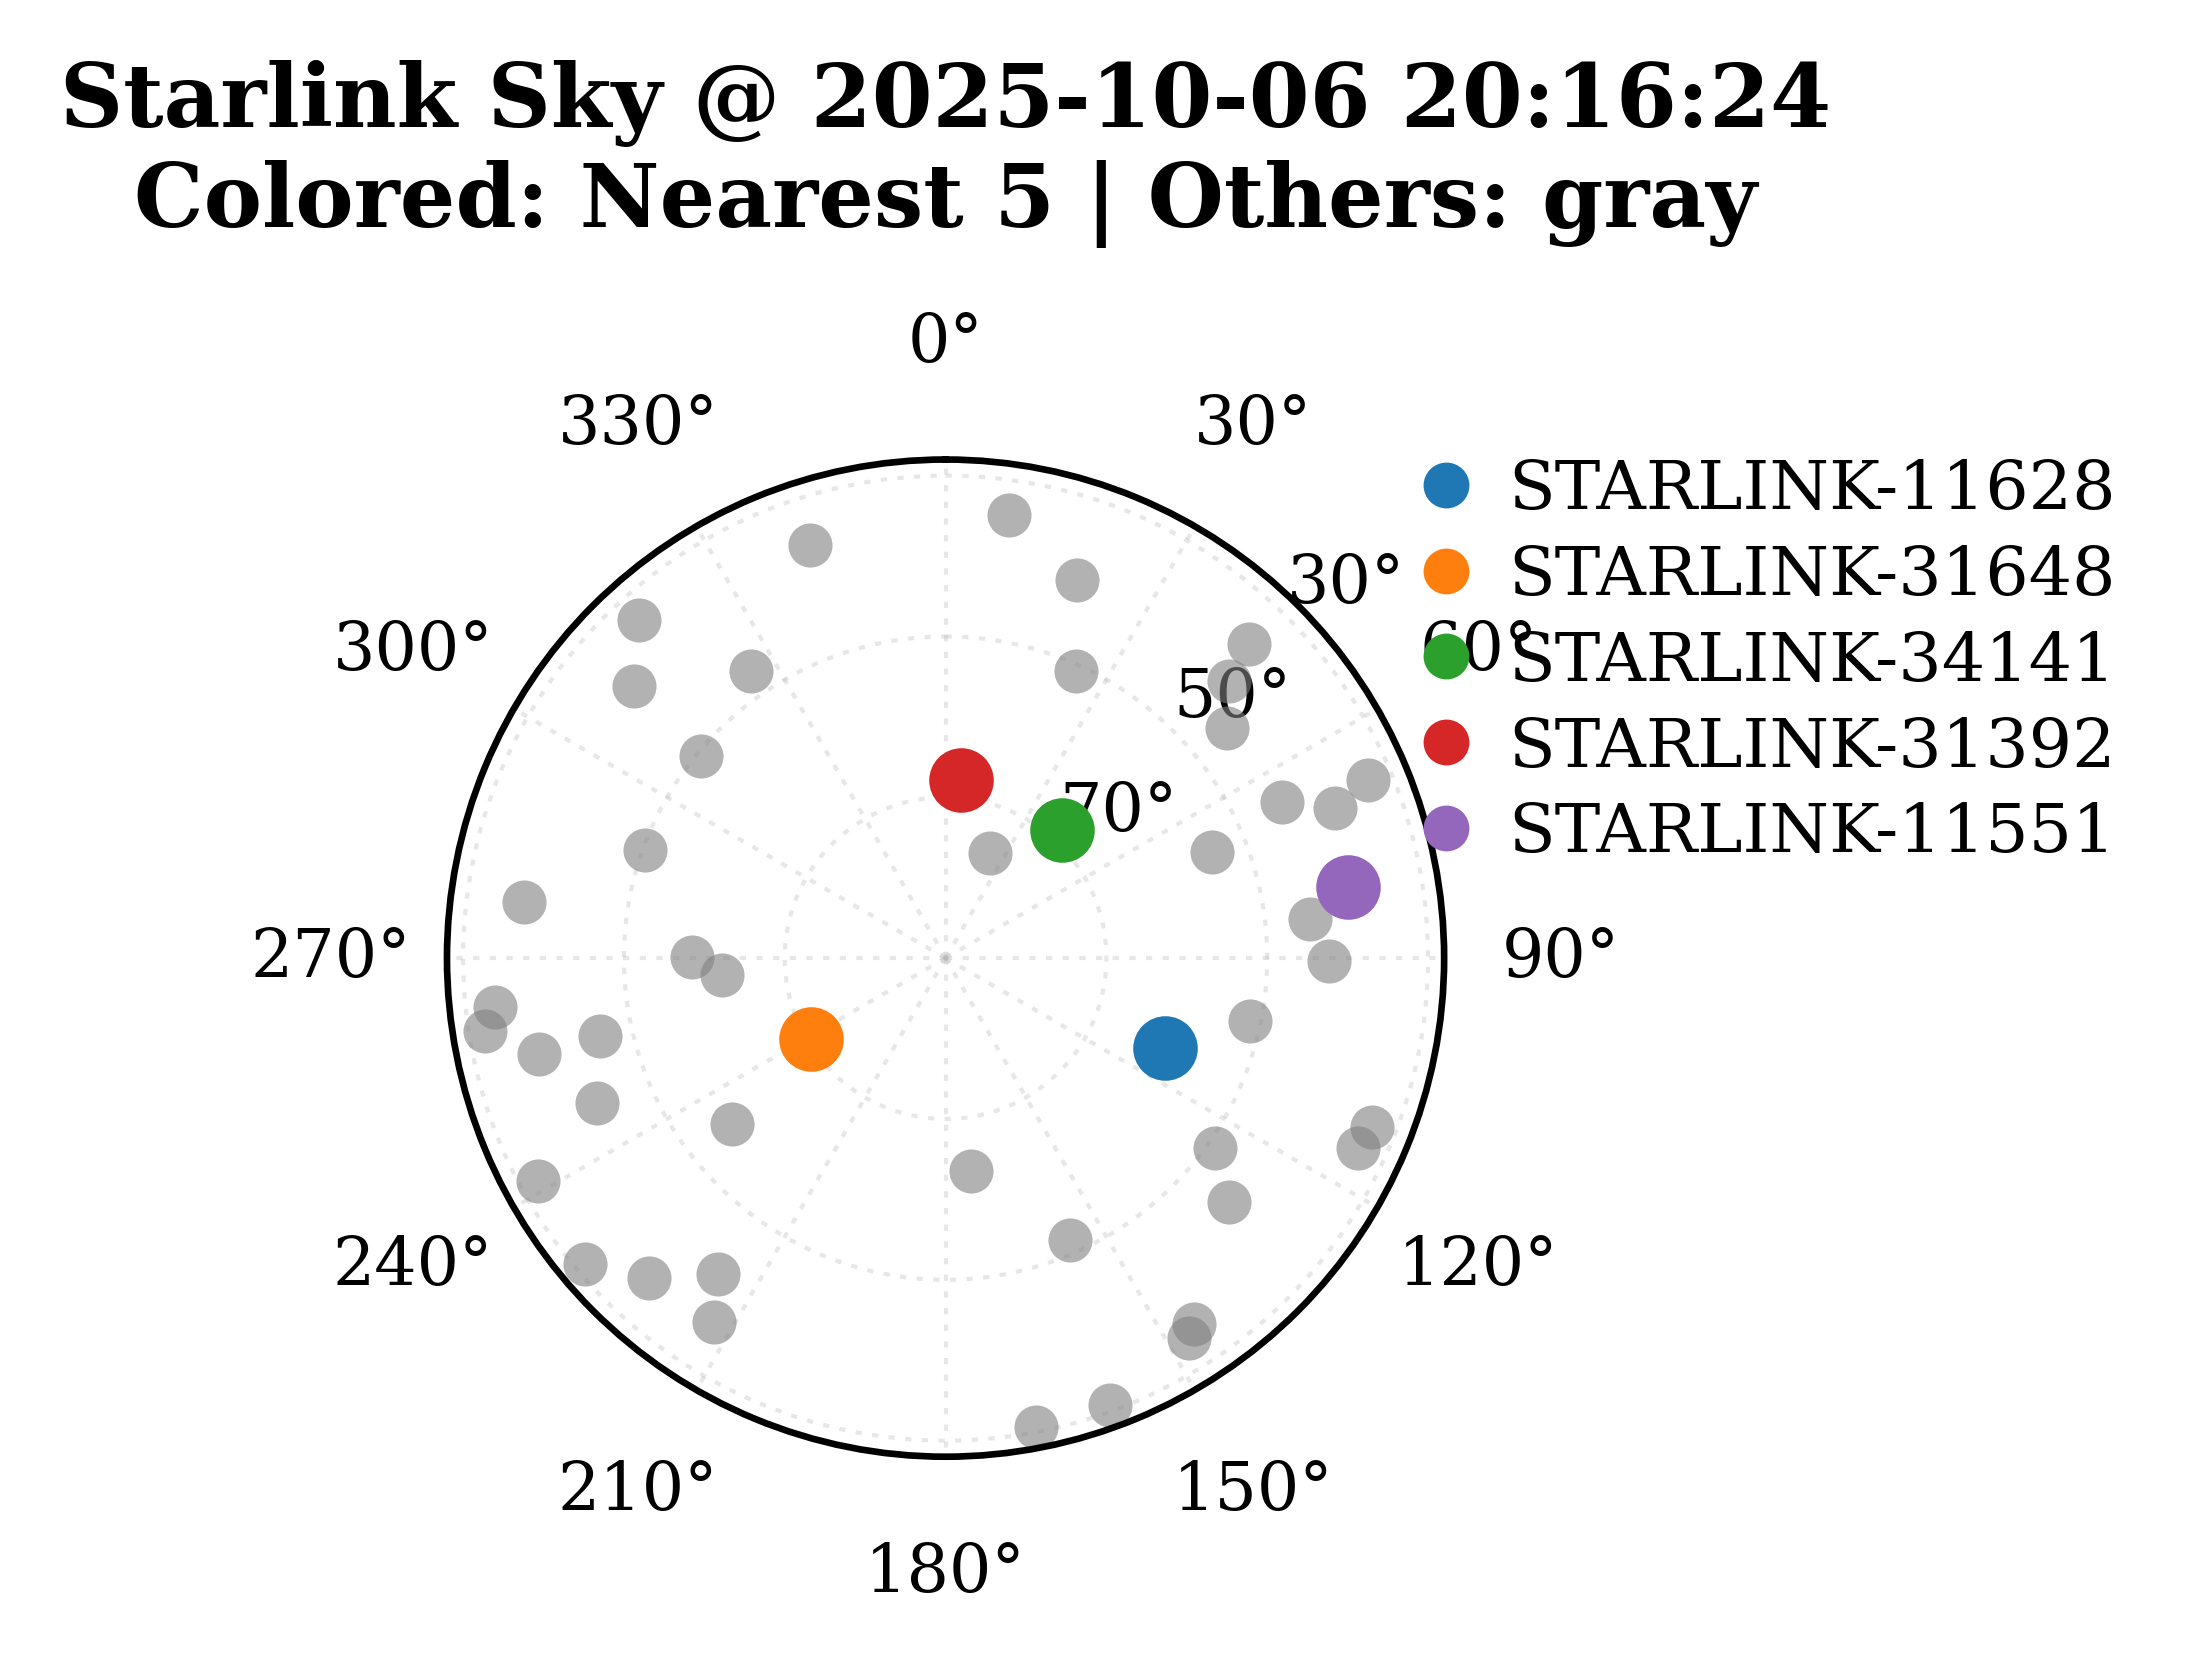

In [6]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from pathlib import Path

# ========= Config =========
CSV_PATH       = Path("starlink_visibility_15min_10s_interval.csv")
ELEV_MIN_DEG   = 30
N_TOP          = 5
RANDOM_SEED    = None
FIG_SIZE_IN    = (3.3, 3.3)   # IEEE 单栏尺寸
DPI_SAVE       = 600
OUT_PNG        = "starlink_sky_ieee_tuned.png"
OUT_PDF        = "starlink_sky_ieee_tuned.pdf"
# =========================

# ---- 字体与样式 ----
base_font = 8.5
plt.rcParams.update({
    "figure.dpi": DPI_SAVE,
    "font.size": base_font,
    "axes.titlesize": base_font + 2,
    "axes.titleweight": "bold",
    "axes.labelsize": base_font,
    "xtick.labelsize": base_font - 0.5,
    "ytick.labelsize": base_font - 0.5,
    "legend.fontsize": base_font - 0.3,
    "axes.linewidth": 0.8,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "serif"],
    "grid.color": "#B0B0B0",
    "grid.alpha": 0.3,
    "grid.linewidth": 0.5,
    "grid.linestyle": (0, (1.5, 2.5)),
})
rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"]  = 42

# ---- 数据 ----
df = pd.read_csv(CSV_PATH)
required_cols = ["Time", "Name", "Azimuth (°)", "Elevation (°)", "Slant km"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

grouped = df.groupby("Time")
time_points = list(grouped.groups.keys())
rng = np.random.default_rng(RANDOM_SEED)
time = rng.choice(time_points)

data = grouped.get_group(time).sort_values(by="Slant km")
topN, others = data.head(N_TOP).copy(), data.iloc[N_TOP:].copy()
topN["Elevation (°)"]   = topN["Elevation (°)"].clip(ELEV_MIN_DEG, 90)
others["Elevation (°)"] = others["Elevation (°)"].clip(ELEV_MIN_DEG, 90)

theta_top   = np.deg2rad(topN["Azimuth (°)"])
radius_top  = 90 - topN["Elevation (°)"]
theta_oth   = np.deg2rad(others["Azimuth (°)"])
radius_oth  = 90 - others["Elevation (°)"]

colormap = cm.get_cmap("tab10")
colors_top = [colormap(i) for i in range(N_TOP)]

# ===== 绘图 =====
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=FIG_SIZE_IN)

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(0, 90 - ELEV_MIN_DEG + 2)
ax.set_axisbelow(True)
ax.set_facecolor("white")
ax.grid(True)

# ---- r-ticks ----
r_outer_limit = 90 - ELEV_MIN_DEG
rticks = np.arange(20, r_outer_limit + 0.1, 20)  # 减少圆环数量
ax.set_yticks(rticks)
ax.set_yticklabels([f"{90 - r:.0f}°" for r in rticks])
ax.set_rlabel_position(45)

# ---- Azimuth ticks ----
ax.set_thetagrids(np.arange(0, 360, 30), labels=[f"{a}°" for a in np.arange(0, 360, 30)])

# ---- Scatter ----
ax.scatter(theta_oth, radius_oth, s=28, c="gray", alpha=0.6, linewidths=0, zorder=1)
for i, (th, rr) in enumerate(zip(theta_top, radius_top)):
    ax.scatter([th], [rr], s=60, c=[colors_top[i]], linewidths=0, zorder=3)

# ---- Legend ----
legend_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               markerfacecolor=colors_top[i], markeredgecolor='none',
               markersize=5.5, label=str(nm).replace(" [DTC]", "").replace("[DTC]", ""))
    for i, nm in enumerate(topN["Name"])
]
ax.legend(handles=legend_handles,
          loc='upper left', bbox_to_anchor=(0.92, 1.05),
          frameon=False, handlelength=1.0, borderpad=0.2,
          labelspacing=0.3, handletextpad=0.4)

# ---- Title ----
ax.set_title(f"Starlink Sky @ {time}\nColored: Nearest {N_TOP} | Others: gray",
             pad=10, fontsize=base_font + 2, fontweight="bold")

# ---- Save ----
plt.tight_layout()
fig.savefig(OUT_PNG, dpi=DPI_SAVE, bbox_inches="tight")
fig.savefig(OUT_PDF, bbox_inches="tight")
print(f"Saved: {OUT_PNG}, {OUT_PDF}")


In [4]:

def track_satellites(csv_path, k=5, tol=0, out_csv="tracked_satellites.csv"):
    """
    Maintain a rolling selection of k satellites by slant-range rank,
    with tolerance 'tol' for how far a satellite may drift in rank before being dropped.
    
    Rules:
      - At the first time, pick the nearest k satellites.
      - At each subsequent time:
          * Keep any currently tracked satellite whose rank <= k + tol (and still visible).
          * Drop tracked satellites whose rank > k + tol or that are not present at this time.
          * Fill vacancies from the current time's nearest satellites not already kept.
          * If none of the previously tracked satellites qualify (i.e., all dropped),
            reseed from the current nearest k.
    Outputs a CSV with one row per (time, selected satellite), including action labels.
    """
    assert tol >= 0, "tol must be >= 0"

    df = pd.read_csv(csv_path)
    # Ensure consistent ordering by time then distance
    # If Time is a string, we can leave it, but sorting ensures chronological processing.
    # Convert to datetime if desired:
    # df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values(["Time", "Slant km"], ascending=[True, True]).reset_index(drop=True)

    # Rank satellites by slant range within each time instant (1 = nearest)
    df["Rank"] = df.groupby("Time")["Slant km"].rank(method="first", ascending=True).astype(int)

    times = df["Time"].unique().tolist()
    current_set = set()

    out_rows = []
    for t in times:
        cur = df[df["Time"] == t].sort_values("Slant km", ascending=True).reset_index(drop=True)

        # Map: name -> (rank, dist)
        rank_map = dict(zip(cur["Name"], cur["Rank"]))
        dist_map = dict(zip(cur["Name"], cur["Slant km"]))
        az_map = dict(zip(cur["Name"], cur["Azimuth (°)"]))
        el_map = dict(zip(cur["Name"], cur["Elevation (°)"]))
        x_map = dict(zip(cur["Name"], cur["x_East (m)"]))
        y_map = dict(zip(cur["Name"], cur["y_North (m)"]))
        z_map = dict(zip(cur["Name"], cur["z_Up (m)"]))
        
        if not current_set:
            # Initial seeding
            selected = cur.head(k)["Name"].tolist()
            actions = ["seed"] * len(selected)
        else:
            # Keep those within allowed rank window and still visible
            kept = []
            actions = []
            for name in list(current_set):
                if (name in rank_map) and (rank_map[name] <= k + tol):
                    kept.append(name)
                    actions.append("keep")
                # else it's implicitly dropped

            # If none survived, reseed
            if len(kept) == 0:
                selected = cur.head(k)["Name"].tolist()
                actions = ["reseed"] * len(selected)
            else:
                # Fill vacancies with closest satellites not already kept
                vacancies = max(0, k - len(kept))
                candidates_ordered = [n for n in cur["Name"].tolist() if n not in kept]
                added = candidates_ordered[:vacancies]
                selected = kept + added
                actions = actions + (["add"] * len(added))

        # Update current set
        current_set = set(selected)

        # Emit rows for this time step
        for name, act in zip(selected, actions):
            out_rows.append({
                "Time": t,
                "Name": name,
                "Action": act,                 # keep / add / seed / reseed
                "Rank": rank_map.get(name, None),
                "Slant km": dist_map.get(name, None),
                "Azimuth (°)": az_map.get(name),
                "Elevation (°)": el_map.get(name),
                "x_East (m)": x_map.get(name),
                "y_North (m)": y_map.get(name),
                "z_Up (m)": z_map.get(name),
            })

    out = pd.DataFrame(out_rows).sort_values(["Time", "Rank"], ascending=[True, True]).reset_index(drop=True)
    out.to_csv(out_csv, index=False)
    return out

# ---- Example usage ----
result = track_satellites("starlink_randtimepoint_400.csv", k=5, tol=0,
                          out_csv="tracked_satellites_400.csv")
  
